# Code to perform inferences 

### Checking metadata to see if I need to worry about that in the predictions

In [2]:
import nibabel as nib
import pandas as pd
import os
import numpy as np

def analyze_nifti_folder(folder_path):
    metadata_list = []
    
    print("Reading files and calculating statistics...")
    for filename in os.listdir(folder_path):
        if filename.endswith(".nii.gz"):
            file_path = os.path.join(folder_path, filename)
            img = nib.load(file_path)
            header = img.header
            
            # Load data to check intensity (useful for Vesuvius ink detection)
            data = img.get_fdata()
            
            meta = {
                "filename": filename,
                "shape": tuple(img.shape),
                "pixdim": tuple(np.round(header.get_zooms(), 4)), # Rounding to avoid float precision noise
                "datatype": str(header.get_data_dtype()),
                "min": np.min(data),
                "max": np.max(data),
                "mean": np.round(np.mean(data), 4),
                "qform": int(header['qform_code']),
                "sform": int(header['sform_code'])
            }
            metadata_list.append(meta)
    
    df = pd.DataFrame(metadata_list)
    
    if df.empty:
        print("No .nii.gz files found.")
        return df

    print(f"\n--- Analysis of {len(df)} files ---")
    
    # 1. Check for global consistency
    # Excluding 'filename', 'min', 'max', 'mean' for the strict metadata check
    meta_cols = ['shape', 'pixdim', 'datatype', 'qform', 'sform']
    consistency_check = df[meta_cols].nunique()
    
    if consistency_check.max() == 1:
        print("✅ Success: Core metadata (pixdim, dtype, orientation) is uniform.")
    else:
        print("⚠️ Metadata discrepancies found (Note: 'shape' is expected for sliding window):")
        print(consistency_check[consistency_check > 1])
        
        print("\n--- Detailed Discrepancies ---")
        for column in meta_cols:
            counts = df[column].value_counts()
            if len(counts) > 1:
                majority_value = counts.idxmax()
                outliers = df[df[column] != majority_value]
                print(f"\nField: [{column}] | Standard: {majority_value}")
                print(f"  Found {len(outliers)} outlier(s). Examples:")
                for _, row in outliers.head(5).iterrows():
                    print(f"    - {row['filename']}: {row[column]}")

    # 2. Intensity Summary (Critical for Ink Detection)
    print("\n--- Intensity Statistics (Voxel Values) ---")
    print(df[['min', 'max', 'mean']].describe().loc[['min', 'max', 'mean']])

    return df

# Usage
path = "/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/Challenge_dataset_updated/train_images_nii_crop"
df = analyze_nifti_folder(path)

Reading files and calculating statistics...


KeyboardInterrupt: 

In [8]:
import nibabel as nib
import os
import pandas as pd

def check_image_label_alignment(image_folder, label_folder):
    mismatches = []
    missing_labels = []
    aligned_count = 0
    
    # We iterate through the image folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(".nii.gz")]
    
    print(f"Comparing {len(image_files)} image-label pairs...")

    for filename in image_files:
        img_path = os.path.join(image_folder, filename)
        lbl_path = os.path.join(label_folder, filename)
        
        if not os.path.exists(lbl_path):
            missing_labels.append(filename)
            continue
            
        # Load headers only (fast)
        img_hdr = nib.load(img_path).header
        lbl_hdr = nib.load(lbl_path).header
        
        img_shape = img_hdr.get_data_shape()
        lbl_shape = lbl_hdr.get_data_shape()
        
        if img_shape != lbl_shape:
            mismatches.append({
                "filename": filename,
                "image_shape": img_shape,
                "label_shape": lbl_shape
            })
        else:
            aligned_count += 1

    # --- Report Results ---
    print(f"\n✅ Properly Aligned: {aligned_count}")
    
    if missing_labels:
        print(f"❌ Missing Labels: {len(missing_labels)} (Images exist but no matching label file found)")
        # for m in missing_labels[:5]: print(f"   - {m}") # Uncomment to see names

    if mismatches:
        print(f"⚠️ Shape Mismatches: {len(mismatches)}")
        df_mismatch = pd.DataFrame(mismatches)
        print(df_mismatch)
    else:
        print("✅ No shape mismatches detected between images and labels.")

    return pd.DataFrame(mismatches)

# Paths
img_dir = "/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/Challenge_dataset_updated/train_images_nii_crop"
lbl_dir = "/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/Challenge_dataset_updated/train_labels_nii_crop"

# Run check
mismatch_df = check_image_label_alignment(img_dir, lbl_dir)

Comparing 786 image-label pairs...

✅ Properly Aligned: 786
✅ No shape mismatches detected between images and labels.


## Test inference class

In [1]:
import sys
import os
from os import listdir
from os.path import join

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath("../utils"))
from infer_class import VesuviusInferer

In [2]:
def plot_3d(data, label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5):
    """
    Plots an orthogonal view (Sagittal, Coronal, Axial) of the 3D data, 
    with an optional segmentation overlay.
    
    Args:
        data (np.ndarray): The primary 3D image data (e.g., MRI scan).
        label_data (np.ndarray, optional): The 3D segmentation mask. Defaults to None.
        slice_indices (tuple, optional): (x, y, z) indices to slice. Defaults to the center.
        title (str): Title of the plot.
        alpha (float): Transparency level for the label overlay (0.0=Invisible, 1.0=Opaque).
    """
    # 1. Input Validation and Shape Handling
    if len(data.shape) not in (3, 4):
        raise ValueError("Input 'data' must be 3D or 4D.")
    if len(data.shape) == 4:
        data = data[:, :, :, 0]
        print("Using first volume (t=0) of 4D anatomical data.")
        
    if label_data is not None:
        if label_data.shape != data.shape:
            raise ValueError("Data and label_data must have matching 3D shapes.")
        if len(label_data.shape) == 4:
            label_data = label_data[:, :, :, 0]
            print("Using first volume (t=0) of 4D label data.")

    # 2. Determine Slice Indices
    x_center, y_center, z_center = [s // 2 for s in data.shape]
    
    if slice_indices:
        x, y, z = slice_indices
    else:
        x, y, z = x_center, y_center, z_center

    # 3. Create the Plot Figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    # 4. Plotting Loop (Sagittal, Coronal, Axial)
    for i, (idx, dim_name) in enumerate(zip([x, y, z], ["Sagittal", "Coronal", "Axial"])):
        
        # Extract slices
        if i == 0: # Sagittal (X-plane)
            data_slice = np.rot90(data[idx, :, :])
            if label_data is not None:
                label_slice = np.rot90(label_data[idx, :, :])
        elif i == 1: # Coronal (Y-plane)
            data_slice = np.rot90(data[:, idx, :])
            if label_data is not None:
                label_slice = np.rot90(label_data[:, idx, :])
        else: # Axial (Z-plane)
            data_slice = np.rot90(data[:, :, idx])
            if label_data is not None:
                label_slice = np.rot90(label_data[:, :, idx])

        # Plot Anatomical Data (Background)
        axes[i].imshow(data_slice, cmap="gray")
        
        # Plot Label Data (Foreground Overlay)
        if label_data is not None:
            # Mask out zero values (background) in the label_slice
            masked_labels = np.ma.masked_where(label_slice == 0, label_slice)
            
            # Use a non-grayscale colormap (e.g., 'jet') for the mask
            # Apply the desired transparency (alpha)
            axes[i].imshow(
                masked_labels, 
                cmap="jet", # Use a vibrant colormap for labels
                alpha=alpha,
                # Interpolation='nearest' makes segmentation lines sharp
                interpolation='nearest' 
            )

        # Set titles and clean up axes
        axes[i].set_title(f"{dim_name} ({['x', 'y', 'z'][i]}={idx})")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
import json
import sys
sys.path.append("../utils")
from main_train_class import main_train_STU_Net

# Warning Suppressions (Must be at the top)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="zarr.codecs.numcodecs._codecs")


CONFIG_FILE = '../configs/infer.json'
with open(CONFIG_FILE, "r") as f:
    config_content = json.load(f)
infer_object = VesuviusInferer(config_content)

Loading weights from: /home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/checkpoints/second_step/wandb/run-20260115_172637-17s1tpfs/files/model/model_best.pth


In [4]:
# prediction
input_data = {
    'image': '/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_images/3925240194.tif',
    'gt': '/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_labels/3925240194.tif'
}
pred, gt, roi_mask = infer_object.infer(input_data, test=False)

  0%|          | 0/183 [00:00<?, ?it/s]Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


In [5]:
# evaluation
results = infer_object.evaluate(predictions=pred, gt=gt, roi_mask=roi_mask)
results

monai.metrics.meandice DiceHelper.__init__:softmax: Argument `softmax` has been deprecated since version 1.5. It will be removed in version 1.7. Use `apply_argmax` instead.
monai.metrics.meandice DiceHelper.__init__:sigmoid: Argument `sigmoid` has been deprecated since version 1.5. It will be removed in version 1.7. Use `threshold` instead.


(tensor([0.2104], device='cuda:0'), tensor([1.], device='cuda:0'))

In [6]:
# saving
infer_object.save_nifti(
    torch_tensor=pred, 
    save_path="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_pred.nii.gz", 
    real_file=None)

infer_object.save_nifti(
    torch_tensor=gt, 
    save_path="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_gt.nii.gz", 
    real_file=None)

infer_object.save_nifti(
    torch_tensor=roi_mask, 
    save_path="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_roi_mask.nii.gz", 
    real_file=None)


In [7]:

infer_object.save_tiff(
    torch_tensor=pred, 
    save_path="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_pred.tif")

infer_object.save_tiff(
    torch_tensor=gt, 
    save_path="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_gt.tif")

infer_object.save_tiff(
    torch_tensor=roi_mask, 
    save_path="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_roi_mask.tif")


#### correcting the orientation when saving the files!

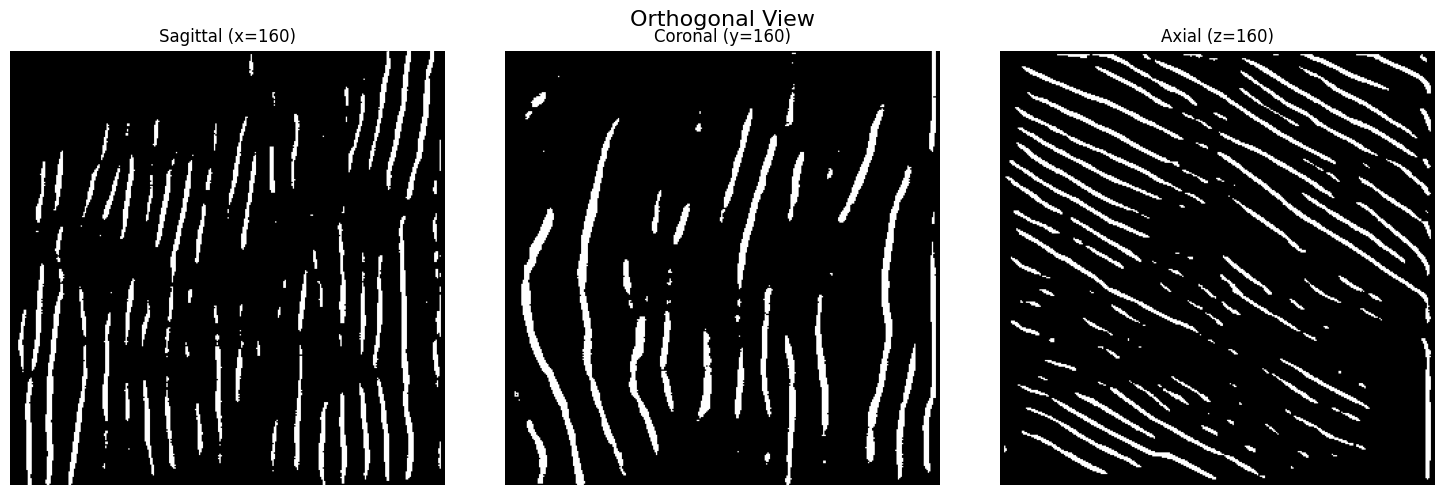

In [8]:
plot_3d(pred[0][0].cpu(), label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5)

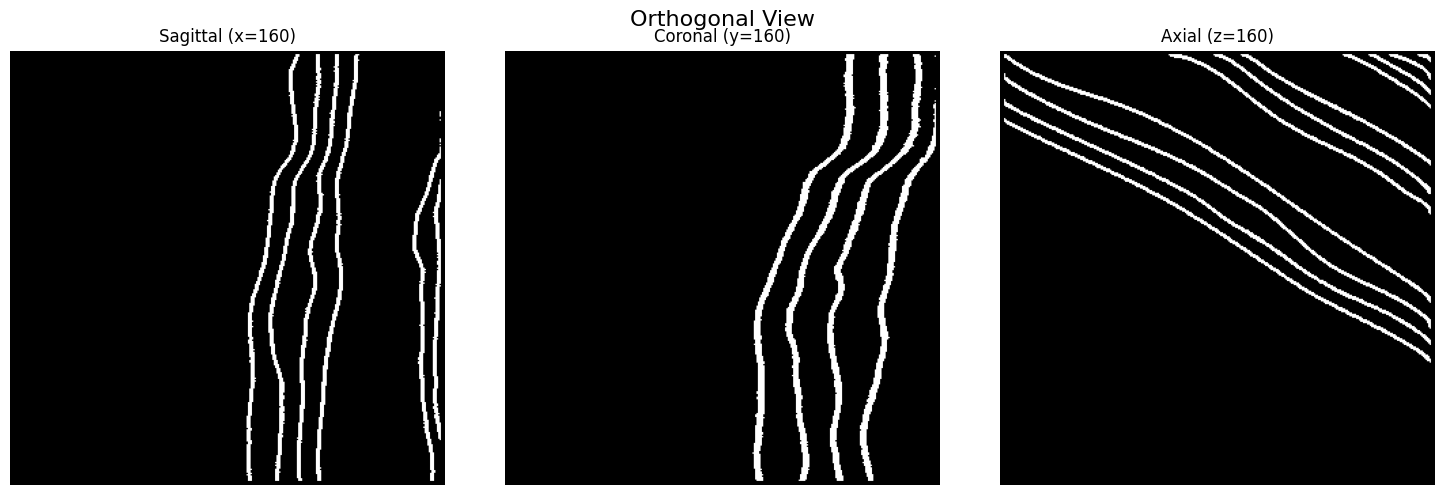

In [9]:
transform_gt = (gt[0][0].cpu().numpy())
#transform_gt = np.transpose(transform_gt, (2, 1, 0))
plot_3d(transform_gt, label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5)

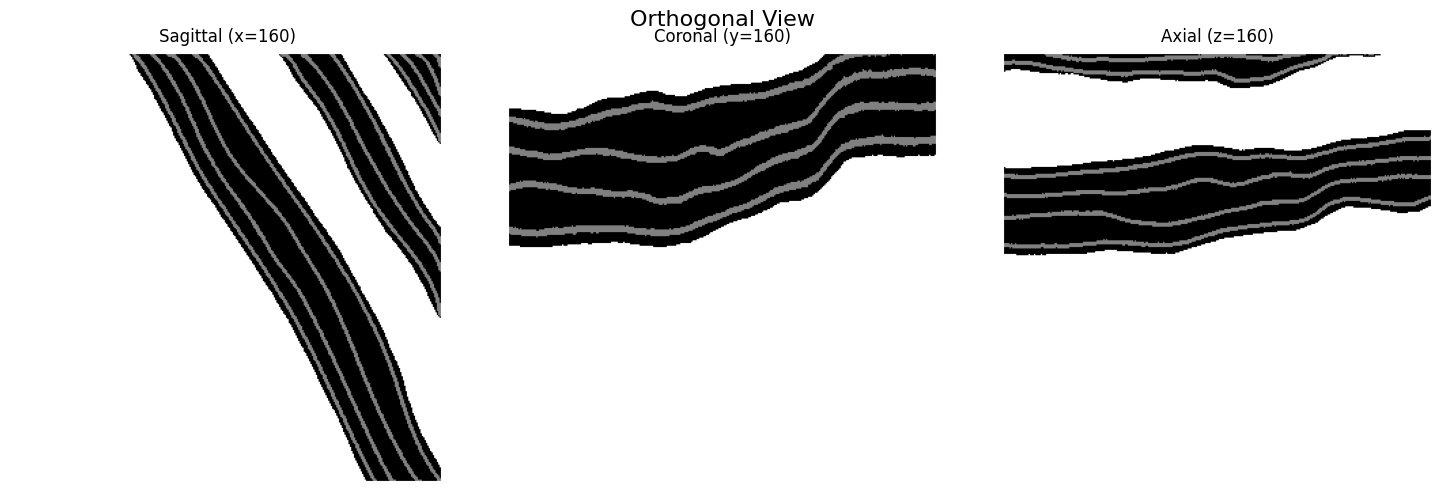

In [11]:
import tifffile
image_array = tifffile.imread(input_data['gt'])

plot_3d(image_array, label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5)

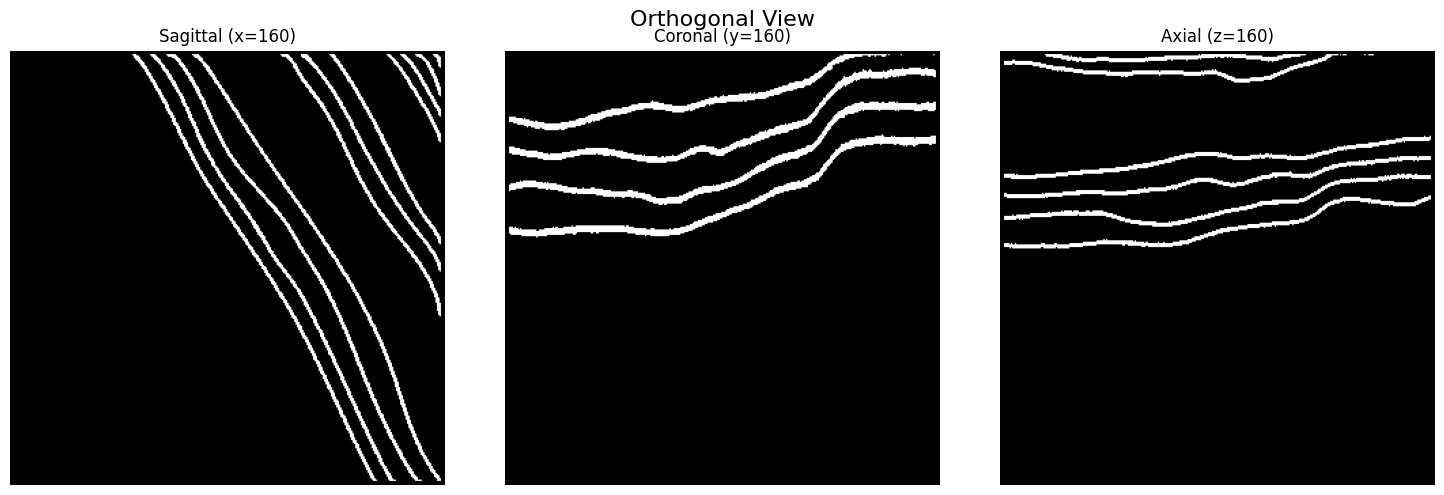

In [13]:
image_array = tifffile.imread("/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_gt.tif")

plot_3d(image_array, label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5)

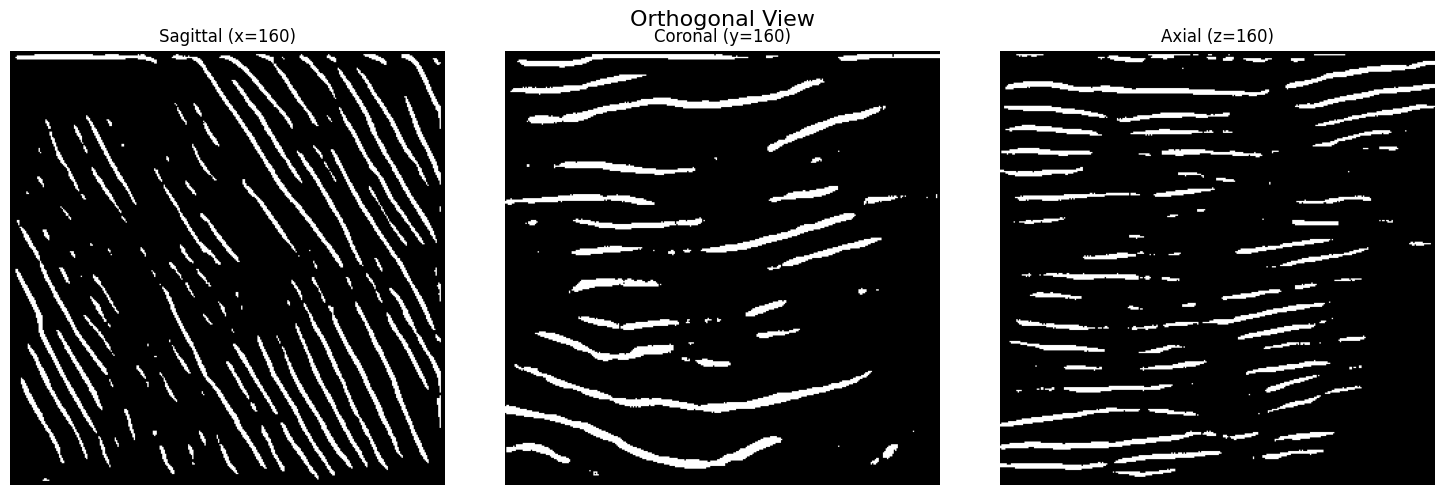

In [12]:
image_array = tifffile.imread("/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/trash/infer/2290837_pred.tif")

plot_3d(image_array, label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5)

#### Create the csv files

In [4]:
# it needs to contain the paths to submission['tif_paths']
# solution -> row['tif_paths'] (paths to the ground truth tifs)
# row['pred_paths'] comes from submission['tif_paths']
import glob
import os
def create_dfs(path_dir):
    # Generate DataFrame
    result_df = glob.glob(os.path.join(path_dir, '**/*.tif'), recursive=True)
    result_df = pd.DataFrame({'tif_paths': result_df})
    result_df['id'] = result_df['tif_paths'].apply(lambda x: os.path.basename(x).split('.')[0])

    # save dataframe to csv (take name from the path_dir last folder)
    csv_name = os.path.basename(os.path.normpath(path_dir)) + '_df.csv'
    result_df.to_csv(os.path.join(path_dir, csv_name), index=False)
    return result_df


create_dfs(
    path_dir="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/val_labels"
    )
#create_dfs(
#    path_dir="/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_pred"
#    )

,tif_paths,id
0,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,1669670049
1,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,541673255
2,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,3090197578
3,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,3924902780
4,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,1566185731
...,...,...
74,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,693501383
75,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,2536049117
76,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,2821927657
77,/home/shadowtwin/Desktop/AI_work/Vesuvius_Chal...,149409101


#### dataset infer function

In [8]:
import glob

def dataset_inference(dataset_path, pred_save_dir):
    """ inference on all cases in a dataset directory and save predictions """
    os.makedirs(pred_save_dir, exist_ok=True)
    all_cases = glob.glob(os.path.join(dataset_path, '**/*.tif'), recursive=True)
    
    for case in all_cases:
        print(f"Processing case: {case}")
        input_data = {
            'image': str(case),
            'gt': None
        }
        
        pred = infer_object.infer(input_data, test=True)
        infer_object.save_tiff(
            torch_tensor=pred, 
            save_path=os.path.join(pred_save_dir, f"{case.split('/')[-1].split('.')[0]}.tif")
        )
    # Creating the dataframe for testing
    infer_object.create_dfs(pred_save_dir)

In [9]:
dataset_inference(
    dataset_path = "/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_images", 
    pred_save_dir = "/home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_pred"
)

Processing case: /home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_images/2290837.tif


  0%|          | 0/183 [00:00<?, ?it/s]Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
100%|██████████| 183/183 [01:03<00:00,  2.89it/s]


Processing case: /home/shadowtwin/Desktop/AI_work/Vesuvius_Challenge/Vesuvius/DataSet/test_images/3925240194.tif


100%|██████████| 183/183 [01:02<00:00,  2.94it/s]
